In [13]:
import json
from typing import DefaultDict
import copy
import pandas as pd
from pandas import DataFrame
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

In [5]:
#Disesuaikan dengan directory data Stocklist.xlsx, excluded_word.xlsx, dan result.json
stock_table = pd.read_excel('StockList.xlsx')
excluded_word = pd.read_excel('excluded_word.xlsx')

In [6]:
with open('result.json', 'rb') as fp:
    data = json.load(fp)

<_io.BufferedReader name='result.json'>

In [7]:
counter = DefaultDict(int)
bydate = DefaultDict(str)
buffer_date = ''

In [8]:
for chats in data['messages'] :
    try :
        if chats['text'] != '':
            tanggal = chats["date"].split("T")[0]
            pengirim = chats["from"]
            teks = chats["text"].replace("\n"," ").replace(",", " ").replace("."," ").lower()
            teks_perkata = teks.split(" ")
            kode_saham = []
            if tanggal != buffer_date :
                counter = DefaultDict(int)
            else :
                pass
            cek_double = []
            for x in teks_perkata :
                if x not in cek_double :
                    if x in stock_table.Kode.values :
                        if x not in excluded_word.values :
                            kode_saham.append(x)
                            cek_double.append(x)
                            counter[x]+=1
                            bydate[tanggal]=copy.copy(counter)
                        else :
                            continue
                    else :
                        continue
                else :
                    continue
            buffer_date = tanggal
#             print(f'{tanggal} | {pengirim} : {teks} - {kode_saham}')
        else :
            continue
    except :
        continue

In [22]:
#Input stockcode
stockcode = input('Masukkan kode saham : ')
mention_counter = [bydate[x][stockcode] for x in bydate]
mention_date = [x for x in bydate]

df = DataFrame([mention_date,mention_counter]).transpose()
df.columns = ('date','mentions')

#Input tanggal
start_date = input('Masukkan tanggal awal (Format: yyyy-mm-dd) : ')
finish_date = input('Masukkan tanggal akhir (Format: yyyy-mm-dd) : ')

print("")
print(df)

Masukkan kode saham : antm
Masukkan tanggal awal (Format: yyyy-mm-dd) : 2021-01-01
Masukkan tanggal akhir (Format: yyyy-mm-dd) : 2021-02-01

           date mentions
0    2019-10-18        0
1    2019-10-19        0
2    2019-10-20        0
3    2019-10-21        0
4    2019-10-22        0
..          ...      ...
527  2021-04-07       10
528  2021-04-08       32
529  2021-04-09        9
530  2021-04-10        1
531  2021-04-11        0

[532 rows x 2 columns]


[*********************100%***********************]  1 of 1 completed


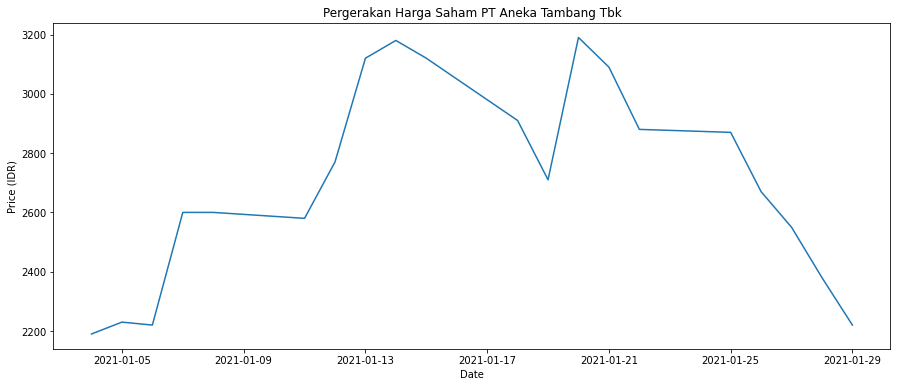

In [23]:
#Cek ekstensi .JK di kode saham
check_stockcode = stockcode.find(".JK")

if check_stockcode == -1:
    stockcode = (stockcode+".JK")
else:
    stockcode

#Input stockcode ke Yahoo Finance    
stockinfo = yf.download(stockcode, start="{}".format(start_date), end="{}".format(finish_date))
stock_price = stockinfo['Adj Close']

#Mengambil Nama Perusahaan
company_info = yf.Ticker("{}".format(stockcode))
company_name = company_info.info["longName"]

#Menampilkan Grafik Pergerakan Harga Saham
plt.figure(figsize=(15,6))
plt.title("Pergerakan Harga Saham "+company_name)
plt.plot(stock_price)
plt.ylabel("Price (IDR)")
plt.xlabel("Date")
plt.show()